# Import Libraries

In [1]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

# Define HyperParameters

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 20

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

# Data Preparation

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 1171
Total videos for testing: 459


,video_name,tag
778,v_PlayingGuitar_g19_c07.avi,PlayingGuitar
287,v_Drumming_g16_c06.avi,Drumming
150,v_CricketShot_g13_c02.avi,CricketShot
219,v_CricketShot_g24_c02.avi,CricketShot
875,v_Punch_g16_c07.avi,Punch
927,v_Punch_g24_c06.avi,Punch
424,v_HorseRiding_g20_c02.avi,HorseRiding
340,v_Drumming_g24_c07.avi,Drumming
532,v_PlayingCello_g18_c04.avi,PlayingCello
900,v_Punch_g20_c04.avi,Punch


In [4]:
def load_video(path, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    # Get the total number of frames in the video.
    video_frames_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
 
    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/MAX_SEQ_LENGTH), 1)
    frames = []
    try:
        for frame_counter in range(MAX_SEQ_LENGTH):
            # Set the current frame position of the video.
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
            
            # Reading the frame from the video. 
            success, frame = cap.read() 
            # Check if Video frame is not successfully read then break the loop
            if not success:
                break
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

    finally:
        cap.release()
    return np.array(frames)

In [5]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [6]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['BoxingPunchingBag', 'CricketShot', 'Drumming', 'HorseRiding', 'PlayingCello', 'PlayingDhol', 'PlayingGuitar', 'Punch', 'ShavingBeard', 'TennisSwing']


In [7]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (1171, 20, 2048)
Frame masks in train set: (1171, 20)


# Model

In [15]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")


    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "\\tmp\\video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/20
25/26 [===========================>..] - ETA: 0s - loss: 2.1669 - accuracy: 0.1550
Epoch 00001: val_loss improved from inf to 2.74467, saving model to \tmp\video_classifier
26/26 [==============================] - 12s 184ms/step - loss: 2.1615 - accuracy: 0.1575 - val_loss: 2.7447 - val_accuracy: 0.0000e+00
Epoch 2/20
25/26 [===========================>..] - ETA: 0s - loss: 1.9713 - accuracy: 0.1988
Epoch 00002: val_loss improved from 2.74467 to 2.58563, saving model to \tmp\video_classifier
26/26 [==============================] - 1s 49ms/step - loss: 1.9721 - accuracy: 0.2002 - val_loss: 2.5856 - val_accuracy: 0.0000e+00
Epoch 3/20
25/26 [===========================>..] - ETA: 0s - loss: 1.8530 - accuracy: 0.2837
Epoch 00003: val_loss did not improve from 2.58563
26/26 [==============================] - 1s 38ms/step - loss: 1.8522 - accuracy: 0.2869 - val_loss: 2.8183 - val_accuracy: 0.0000e+00
Epoch 4/20
25/26 [===========================>..] - ETA: 0s - loss: 1.7237 - ac

Test video path: v_PlayingGuitar_g05_c04.avi
  CricketShot: 12.81%
  PlayingGuitar: 12.28%
  PlayingCello: 11.73%
  HorseRiding: 11.19%
  TennisSwing:  9.94%
  PlayingDhol:  9.85%
  ShavingBeard:  9.13%
  Drumming:  8.73%
  BoxingPunchingBag:  7.63%
  Punch:  6.71%



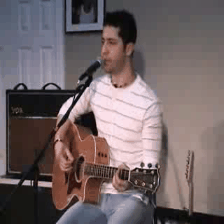

In [16]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])